In [1]:
import os
import numpy as np
import copy
import cv2 as cv
import json
import operator
import matplotlib.pyplot as plt

In [3]:
import import_ipynb
from image_processing_functions import read_image, canny_edge_response, adaptive_gaussian_threshold, adaptive_mean_threshold, automatic_canny_edge_response, harris_corner_response, hough_line_detect_response, hough_line_intersections, houghp_line_detect_response, houghp_line_points, corners_on_image, furthest_points_on_image, crop_image, warp_image, hough_line_intersections_coord
from hierarchical_clusterizations import cluster_lines, augment_cluster_lines, cluster_points, augment_cluster_points
# from kmeans_clusterizations import kmeans_cluster_lines, augment_kmcluster_lines, kmeans_cluster_points, augment_kmcluster_points
from chessboard_localizations import localize_top_chessboard, localize_top_chessboard_prob, localize_angled_chessboard, localize_angled_chessboard_prob

In [4]:
filename = '../datasets/dataset 1/data/0.jpg'
filename_2 = "../datasets/dataset 2/train/0028.png"

Loops: 3
Distances between adjacent points [ -42.051147   98.70117  -101.4942  ]
Crop because of distances: False
Differences between distances: [679.0, 641.0, 734.0, 627.0]
Crop because of points too close: False
Distances between adjacent points [ -42.051147   98.70117  -101.4942  ]
Differences between distances: [679.0, 641.0, 734.0, 627.0]
warp


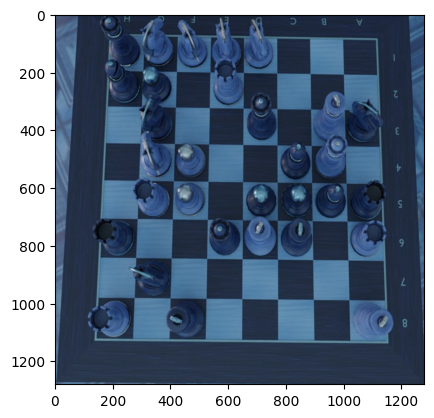

In [5]:
chessboard = localize_top_chessboard(read_image(filename), corner_setup=40)

{'img': array([[[ 77,  94, 127],
         [ 77,  94, 127],
         [ 77,  94, 127],
         ...,
         [ 60,  93, 132],
         [ 57,  90, 129],
         [ 53,  86, 125]],
 
        [[ 77,  94, 127],
         [ 77,  94, 127],
         [ 77,  94, 127],
         ...,
         [ 60,  94, 132],
         [ 57,  90, 129],
         [ 53,  86, 125]],
 
        [[ 77,  94, 127],
         [ 77,  94, 127],
         [ 77,  94, 127],
         ...,
         [ 59,  94, 131],
         [ 57,  90, 129],
         [ 53,  86, 125]],
 
        ...,
 
        [[ 81, 102, 133],
         [ 82, 102, 133],
         [ 81, 101, 132],
         ...,
         [ 37,  51,  73],
         [ 34,  48,  73],
         [ 31,  47,  73]],
 
        [[ 81, 101, 132],
         [ 80, 100, 131],
         [ 80,  99, 130],
         ...,
         [ 36,  51,  73],
         [ 33,  49,  73],
         [ 31,  48,  74]],
 
        [[ 80, 100, 131],
         [ 80,  99, 130],
         [ 79,  99, 130],
         ...,
         [ 34,  50,  

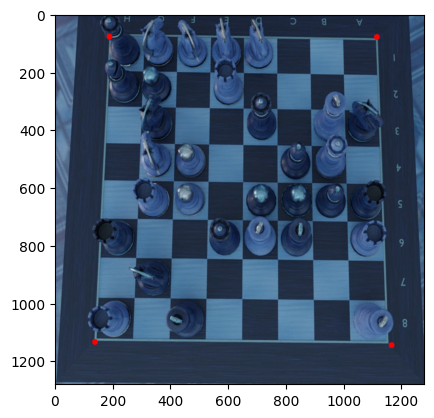

In [6]:
lower_zoom = 40
square_size = 125

def calibrate_piece_image(point, lower_zoom, square_size):
    square = [[point[0] - lower_zoom, point[1] + lower_zoom],
          [point[0] - lower_zoom, (point[1] + lower_zoom) - square_size],
          [point[0] + lower_zoom + square_size, point[1] - (square_size + lower_zoom)],
          [(point[0] + lower_zoom) + square_size, point[1] + lower_zoom]]
    crop_image(chessboard['calibration'], square)

def get_corners_from_warp_image(chessboard_img, low_thr=90, high_thr=100, limit_lines=True, limit_points=True):
    canny_filter = canny_edge_response(chessboard_img['calibration'], low_thr=low_thr, high_thr=high_thr)
    hough_lines = hough_line_detect_response(canny_filter, threshold=100)

    if limit_lines:
        hough_lines['coords'] = [values for values in hough_lines['coords'] if not np.any((-50 <= np.array(values)) & (np.array(values) <= 50)) and not np.any((1280 - 50 <= np.array(values)) & (np.array(values) <= 1280 + 50)) and not (abs(abs(values[3]) - abs(values[1])) > 150 and abs(abs(values[2]) - abs(values[0])) > 150)]

    clusters = cluster_lines(hough_lines)
    new_lines = augment_cluster_lines(clusters)
    hough_lines['coords'] = list(new_lines['dict'].values())
    hough_lines['list'] = list(new_lines['rht_val'].values())
    hough_lines['count'] = len(hough_lines['coords'])

    ok = False
    while not ok:
        clusters = cluster_lines(hough_lines)
        new_lines = augment_cluster_lines(clusters)
        if hough_lines['count'] > len(new_lines['dict']):
            hough_lines['coords'] = list(new_lines['dict'].values())
            hough_lines['list'] = list(new_lines['rht_val'].values())
            hough_lines['count'] = len(hough_lines['coords'])
        elif hough_lines['count'] == len(new_lines['dict']):
            ok = True

    hough_intersections = hough_line_intersections_coord(hough_lines)

    if limit_points:
        hough_intersections['list'] = [values for values in hough_intersections['list'] if not np.any((-70 <= np.array(values)) & (np.array(values) <= 70)) and not np.any((1280 - 70 <= np.array(values)) & (np.array(values) <= 1280 + 70))]

    clusters = cluster_points(hough_intersections)
    new_points = augment_cluster_points(clusters)
    hough_intersections['list'] = list(new_points['dict'].values())
    hough_intersections['count'] = len(hough_intersections['list'])

    ok = False
    while not ok:
        new_points['list'] = [[int(x), int(y)] for x, y in new_points['dict'].values()]
        clusters = cluster_points(new_points)
        new_points = augment_cluster_points(clusters)
        if hough_intersections['count'] > len(new_points['dict']):
            hough_intersections['list'] = list(new_points['dict'].values())
            hough_intersections['count'] = len(hough_intersections['list'])
        elif hough_intersections['count'] == len(new_points['dict']):
            ok = True

    hough_intersections['list'] = [list(values) for values in hough_intersections['list']]
    hough_intersections['list'].sort()

    image_copy = np.copy(chessboard['calibration'])
    for intersection in hough_intersections['list']:
        cv.circle(image_copy, (round(intersection[0]), round(intersection[1])), 10, (255, 0, 0), 3)

    plt.imshow(image_copy)

    corners = corners_on_image(hough_intersections)
    result = {
        'img': image_copy,
        'corners': corners
    }
    return result

get_corners_from_warp_image(chessboard, low_thr=110, high_thr=120, limit_lines=True, limit_points=True)

In [ ]:
get_corners_from_warp_image(localize_top_chessboard(read_image('../datasets/dataset 1/data/5.jpg'), corner_setup=40), 50, 60, True, True)

Loops: 1
Distances between adjacent points [ 45.392822   9.740967 -54.786926]
Crop because of distances: False
Differences between distances: [422.0, 448.0, 438.0, 377.0]
Crop because of points too close: False
Distances between adjacent points [ 45.392822   9.740967 -54.786926]
Differences between distances: [422.0, 448.0, 438.0, 377.0]
warp


{'img': array([[[ 77,  94, 127],
         [ 77,  94, 127],
         [ 77,  94, 127],
         ...,
         [ 60,  93, 132],
         [ 57,  90, 129],
         [ 53,  86, 125]],
 
        [[ 77,  94, 127],
         [ 77,  94, 127],
         [ 77,  94, 127],
         ...,
         [ 60,  94, 132],
         [ 57,  90, 129],
         [ 53,  86, 125]],
 
        [[ 77,  94, 127],
         [ 77,  94, 127],
         [ 77,  94, 127],
         ...,
         [ 59,  94, 131],
         [ 57,  90, 129],
         [ 53,  86, 125]],
 
        ...,
 
        [[ 81, 102, 133],
         [ 82, 102, 133],
         [ 81, 101, 132],
         ...,
         [ 37,  51,  73],
         [ 34,  48,  73],
         [ 31,  47,  73]],
 
        [[ 81, 101, 132],
         [ 80, 100, 131],
         [ 80,  99, 130],
         ...,
         [ 36,  51,  73],
         [ 33,  49,  73],
         [ 31,  48,  74]],
 
        [[ 80, 100, 131],
         [ 80,  99, 130],
         [ 79,  99, 130],
         ...,
         [ 34,  50,  

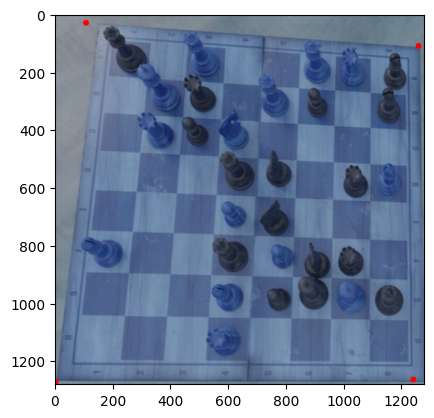

In [19]:
get_corners_from_warp_image(localize_top_chessboard(read_image('../datasets/dataset 1/data/5.jpg'), corner_setup=40), 50, 60, False, False)

Loops: 1
Distances between adjacent points [  68.35626  222.93066 -278.33966]
Crop because of distances: True
Differences between distances: [659.0, 728.0, 943.0, 662.0]
Crop because of points too close: False
Distances between adjacent points [  68.35626  222.93066 -278.33966]
crop
Distances between adjacent points [ 34.57074   34.89337  -47.053833]
Loops: 4
Distances between adjacent points [ 34.57074   34.89337  -47.053833]
Crop because of distances: False
Differences between distances: [650.0, 688.0, 716.0, 663.0]
Crop because of points too close: False
Distances between adjacent points [ 34.57074   34.89337  -47.053833]
Differences between distances: [650.0, 688.0, 716.0, 663.0]
warp


{'img': array([[[ 77,  94, 127],
         [ 77,  94, 127],
         [ 77,  94, 127],
         ...,
         [ 60,  93, 132],
         [ 57,  90, 129],
         [ 53,  86, 125]],
 
        [[ 77,  94, 127],
         [ 77,  94, 127],
         [ 77,  94, 127],
         ...,
         [ 60,  94, 132],
         [ 57,  90, 129],
         [ 53,  86, 125]],
 
        [[ 77,  94, 127],
         [ 77,  94, 127],
         [ 77,  94, 127],
         ...,
         [ 59,  94, 131],
         [ 57,  90, 129],
         [ 53,  86, 125]],
 
        ...,
 
        [[ 81, 102, 133],
         [ 82, 102, 133],
         [ 81, 101, 132],
         ...,
         [ 37,  51,  73],
         [ 34,  48,  73],
         [ 31,  47,  73]],
 
        [[ 81, 101, 132],
         [ 80, 100, 131],
         [ 80,  99, 130],
         ...,
         [ 36,  51,  73],
         [ 33,  49,  73],
         [ 31,  48,  74]],
 
        [[ 80, 100, 131],
         [ 80,  99, 130],
         [ 79,  99, 130],
         ...,
         [ 34,  50,  

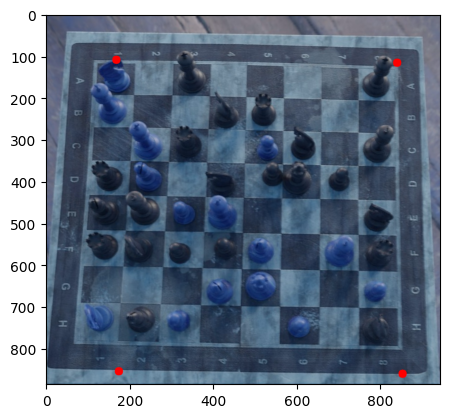

In [62]:
def find_chessboard_corners(img):
    found = False
    low_thr, high_thr = 110, 120
    lower_thr = 0

    # the conditions about deleting the features near the limits of the image is still in progress
    while not found:
        try:
            corner_result = get_corners_from_warp_image(img, low_thr - lower_thr, high_thr - lower_thr, True, True)
            corner_set = []
            for point in corner_result['corners']['list']:
                if point not in corner_set:
                    corner_set.append(point)
            if len(corner_set) == 4:
                found = True
            else:
                lower_thr += 10
        except:
            print("Lowering the threshold interval...")
            lower_thr += 10
    return corner_result

new_chessboard = localize_top_chessboard(read_image('../datasets/dataset 1/data/3.jpg'), corner_setup=40)
localize_crop = localize_top_chessboard(new_chessboard['calibration'], corner_setup=40)
find_chessboard_corners(localize_crop)

Loops: 1
Distances between adjacent points [ 20.227173  50.59607  -52.39093 ]
Crop because of distances: False
Differences between distances: [554.0, 577.0, 624.0, 566.0]
Crop because of points too close: False
Distances between adjacent points [ 20.227173  50.59607  -52.39093 ]
Differences between distances: [554.0, 577.0, 624.0, 566.0]
warp
Images of pieces generated successfully


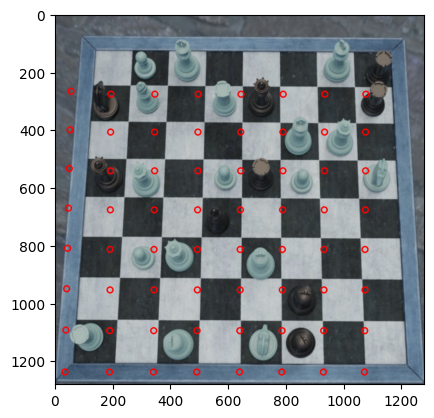

In [67]:
def find_other_corners(chessboard, corners):
    coords = corners['corners']['list'].copy()
    left_coord = max(coords[0][0], coords[3][0])
    left_diff = abs(coords[3][0] - coords[0][0])
    left_diff = left_diff / 8
    right_coord = min(coords[1][0], coords[2][0])
    right_diff = abs(coords[2][0] - coords[1][0])
    right_diff = right_diff / 8
    up_coord = max(coords[0][1], coords[1][1])
    up_diff = abs(coords[1][1] - coords[0][1])
    up_diff = up_diff / 8
    down_coord = min(coords[2][1], coords[3][1])
    down_diff = abs(coords[3][1] - coords[2][1])
    down_diff = down_diff / 8

    # these values are different to most calibrations, it could take longer to think of a solution to handle all these pictures properly
    image_copy = np.copy(chessboard['calibration'])
    point = coords[3]
    square_y = 0
    lower_zoom = 40
    square_size = 150
    squares = []
    while square_y < 8:
        square_x = 0
        while square_x < 8:
            x_next_point = (105 - 1 * square_x) * square_x + (left_diff * 4 * square_y)
            y_next_point = (145 - 1 * square_y) * square_y + left_diff * square_y
            if square_x != 0:
                x_next_point = (155 - 1 * square_x) * square_x + left_diff * square_y
                y_next_point = (145 - 1 * square_y) * square_y - left_diff * square_y # * (square_y - square_x)
            # cv.circle(image_copy, (round((point[0] + x_next_point) - lower_zoom), round((point[1] - y_next_point) + lower_zoom)), 10, (255, 0, 0), 3)
            square = [[(point[0] + x_next_point) - lower_zoom, (point[1] - y_next_point) + lower_zoom],
              [(point[0] + x_next_point) - lower_zoom, ((point[1] - y_next_point) - lower_zoom) - square_size],
              [(point[0] + x_next_point) + lower_zoom + square_size, (point[1] - y_next_point) - (square_size + lower_zoom)],
              [((point[0] + x_next_point) + lower_zoom) + square_size, (point[1] - y_next_point) + lower_zoom]]
            cv.circle(image_copy, (round((point[0] + x_next_point) - lower_zoom), round((point[1] - y_next_point) + lower_zoom)), 10, (255, 0, 0), 3)
            squares.append(square)
            square_x += 1
        square_y += 1

    plt.imshow(image_copy)

    for index in range(len(squares)):
        piece_image = crop_image(chessboard['calibration'], squares[index])
        cv.imwrite('processed_data/64_' + str(index) + '.png', piece_image)

    plt.imshow(image_copy)
    print("Images of pieces generated successfully")

new_chessboard = localize_top_chessboard(read_image('../datasets/dataset 1/data/64.jpg'), corner_setup=40)
chessboard_corners = find_chessboard_corners(new_chessboard)
find_other_corners(new_chessboard, chessboard_corners)